### Accumulate and visualize predictions on measurements

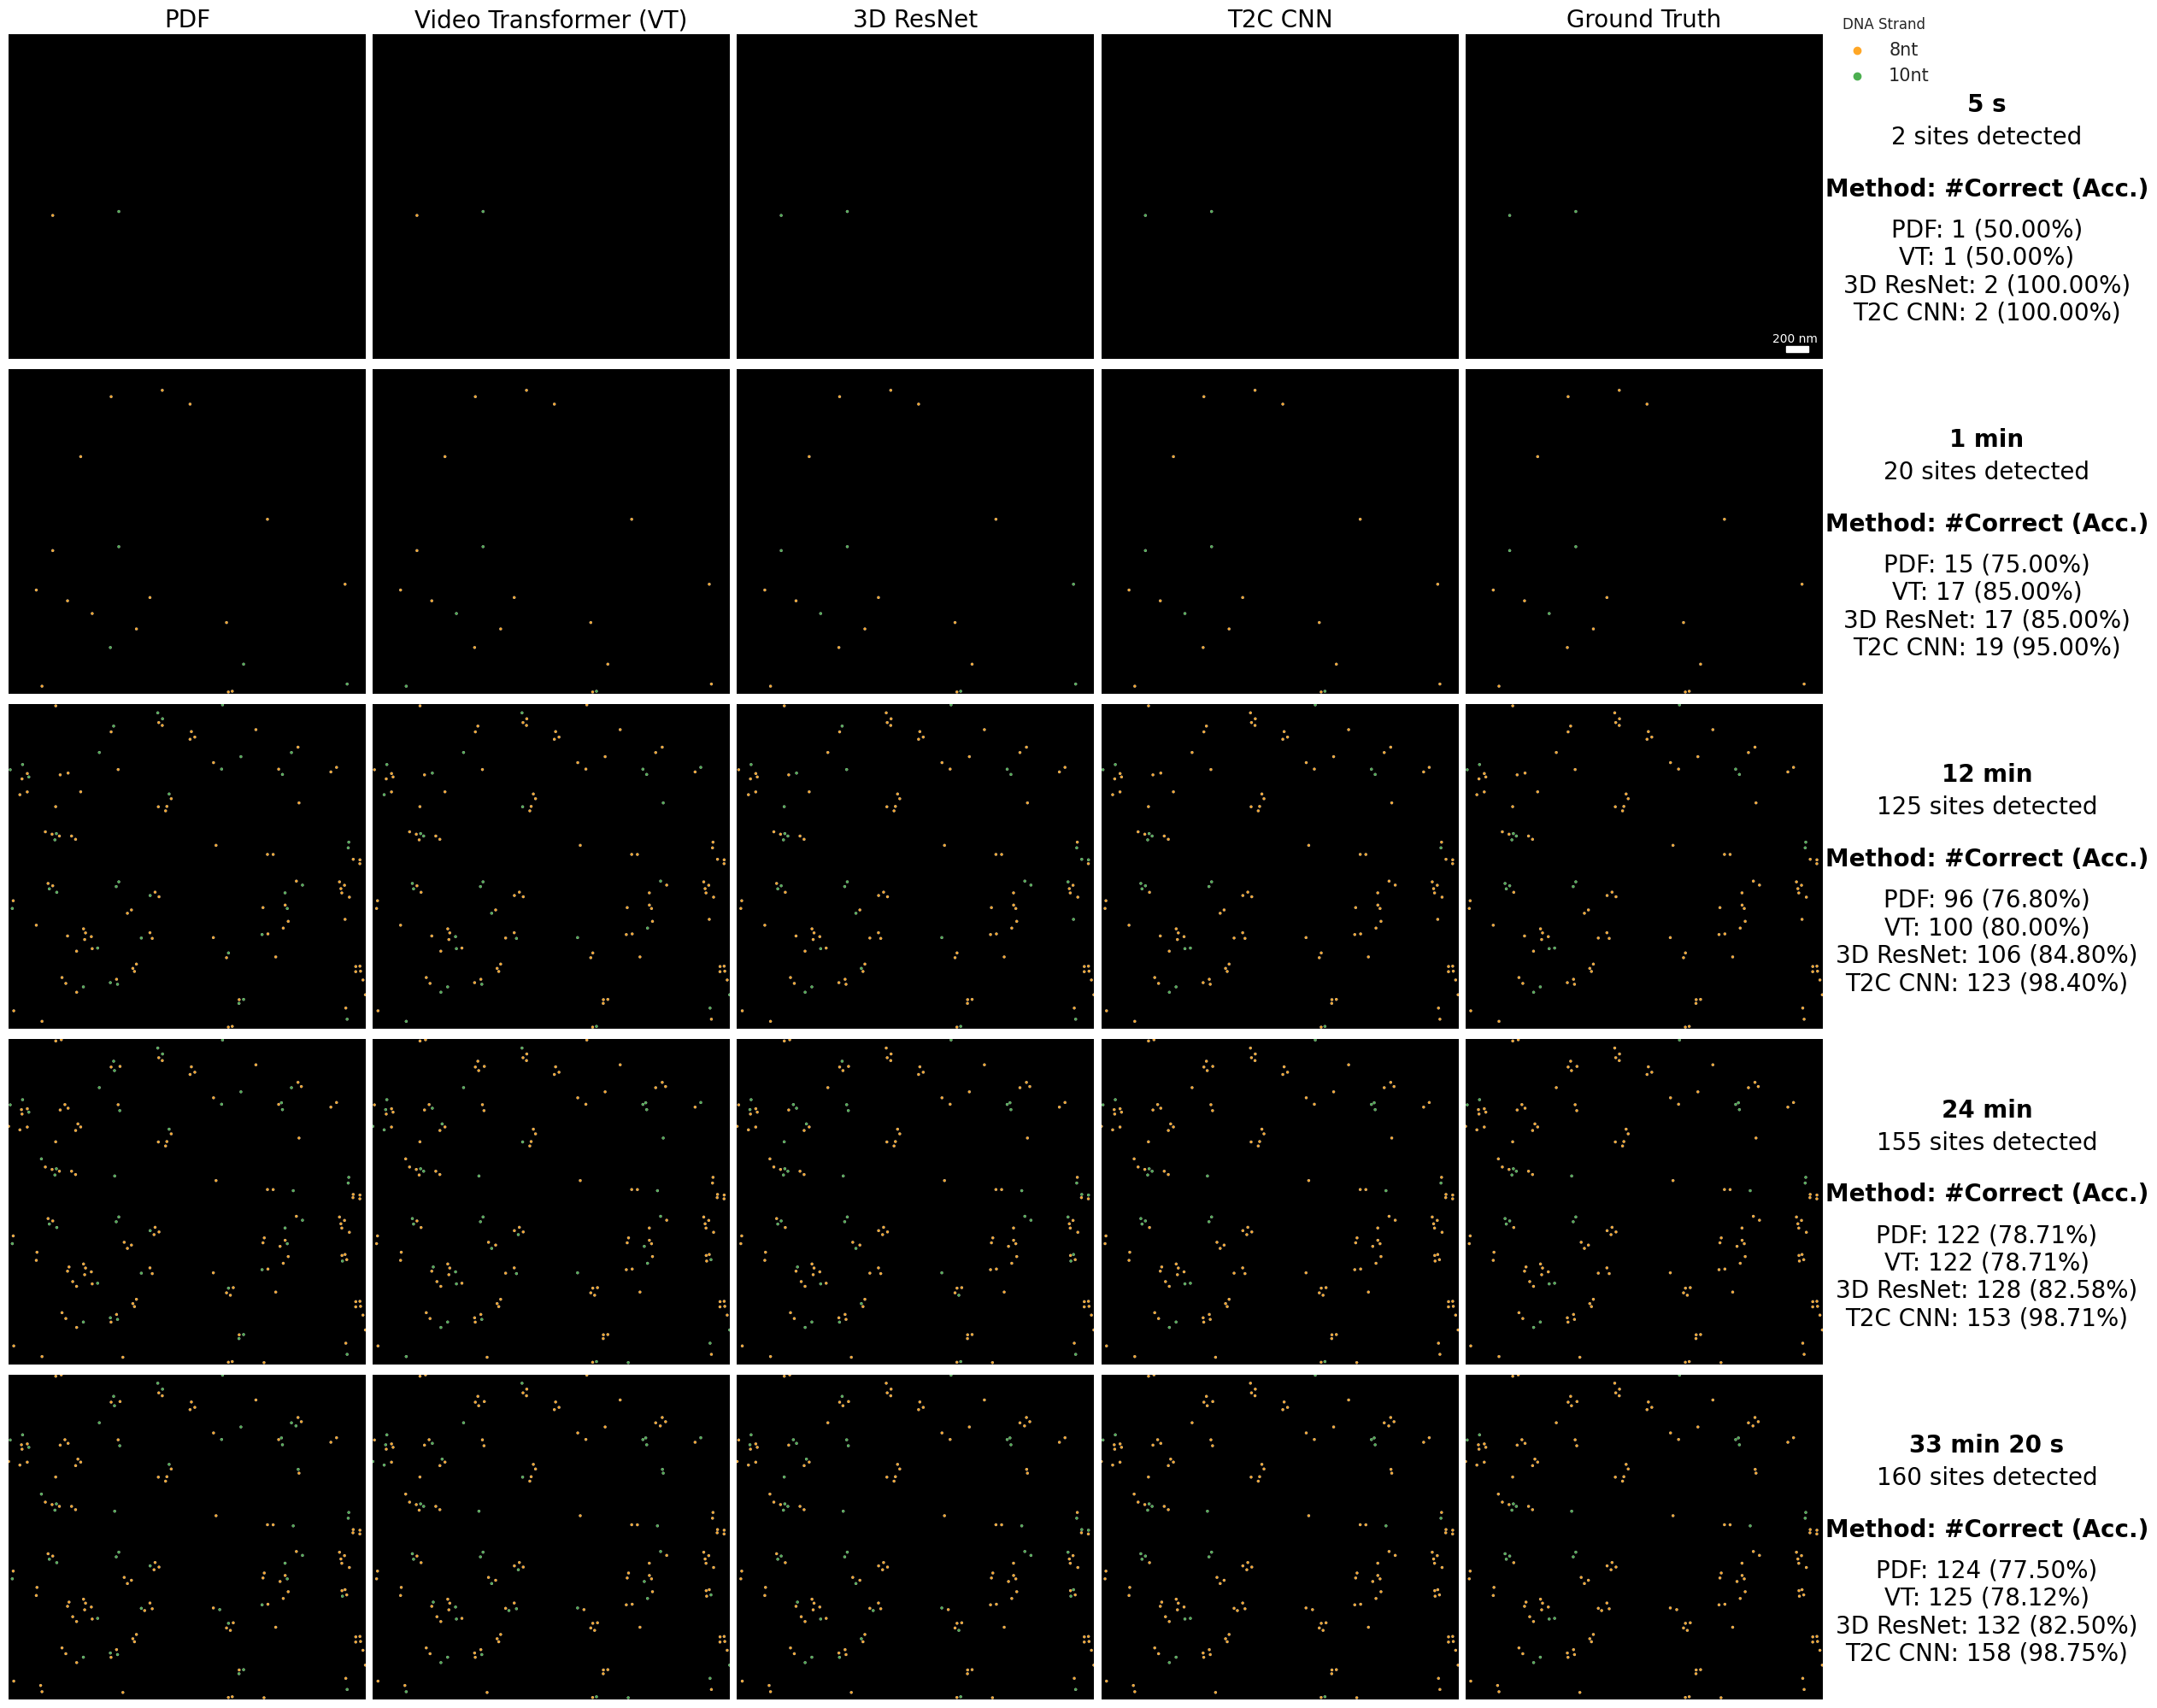

In [ ]:
import nexusformat.nexus as nx
import pandas as pd
import numpy as np
import os, ast
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

def add_prediction_column(domain_idx, method, group_pred_df, observations_df, output_csv_path):
    """
    Add a 'prediction' column to the observations CSV table by merging with group-prediction associations.

    :param group_pred_csv_path: Path to the CSV file containing group-prediction associations.
    :param observations_csv_path: Path to the CSV file containing observations for all groups.
    :param output_csv_path: Path to save the updated observations CSV file with the 'prediction' column added.
    """

    # Ensure the group_pred_df has 'Group' and pred_column_dict[method] columns
    if 'Group' not in group_pred_df.columns or pred_column_dict[method] not in group_pred_df.columns:
        raise ValueError(f"group_pred_df must contain 'Group' and '{pred_column_dict[method]}' columns.")

    # Ensure the observations_df has a 'group' column to merge on
    if 'group' not in observations_df.columns:
        raise ValueError("observations_df must contain a 'group' column.")

    # Group group_pred_df by 'Group' and 'Label' and aggregate 'Prediction' into lists
    if method != 'PDF':
        group_pred_df = group_pred_df.groupby(['Group', 'Label'], as_index=False).agg({'Prediction': list, 'Class_1_Prob': list, 'Class_2_Prob': list})
    
    # Merge the DataFrames on the 'Group' column from group_pred_df and 'group' column from observations_df
    merged_df = pd.merge(observations_df, group_pred_df, left_on=['group', 'domain'], right_on=['Group', 'Label'], how='left', suffixes=('_obs', '_pred'))

    # Drop the additional 'Group' column from the merge
    merged_df.drop(columns=['Group'], inplace=True)

    # Prepare the df to save as hdf5
    merged_df.dropna(subset=['group'], inplace=True)
    merged_df = merged_df.reset_index(drop=True)
    merged_df = merged_df.astype({'group': np.int32})

    # Save the updated DataFrame to a new CSV file
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    merged_df.to_csv(output_csv_path, index=False)

    return merged_df

def split_into_events(group_frames):
    # Return an empty list if group_frames is empty
    if len(group_frames) == 0:
        return []
    
    # Ensure group_frames is sorted for consecutive detection
    group_frames = np.sort(group_frames)

    # Fill in missing frames for gaps <= 10
    filled_frames = []
    for i in range(len(group_frames) - 1):
        start, end = group_frames[i], group_frames[i + 1]
        # Add all frames in range if gap is <= 10, otherwise just add the start frame
        filled_frames.extend(range(start, end + 1) if (end - start) <= 10 else [start])
    filled_frames.append(group_frames[-1])  # Add the last frame

    # Convert back to array to use numpy's split
    filled_frames = np.array(filled_frames)

    # Identify indices where there's a break in consecutive values > 10
    breaks = np.where(np.diff(filled_frames) > 10)[0] + 1

    # Use these breakpoints to split filled_frames into events
    events = np.split(filled_frames, breaks)
    
    return [event.tolist() for event in events if len(event) > 0]

def count_events_up_to_frame(events, frame_idx):
    count = 0
    for event in events:
        # Check if the event has any frames up to and including frame_idx
        if len(event) > 0 and event[0] <= frame_idx:
            # If the last frame in the event is greater than frame_idx, consider only up to frame_idx
            if event[-1] > frame_idx:
                break
            count += 1
    return count

def plot_spots(method_pred_dict, measurement_times, save_dir, domain_idx, measurement_times_str, legend_list, pred_column_dict):
    # Set the plot style
    sns.set(style="whitegrid")

    # Define a high-contrast color palette for predictions
    # BUG one: colors = ['#FFA726', '#4CAF50'], which unintendedly mapped '10nt' to the first color if all predictions are '10nt'
    colors = {'8nt': '#FFA726', '10nt': '#4CAF50'}

    num_methods = len(method_pred_dict)
    fig, axes = plt.subplots(nrows=len(measurement_times), ncols=num_methods, figsize=(25, 20), facecolor='white')
    fig.subplots_adjust(hspace=0.05, wspace=0.05)  # Reduce white space between subplots for a tighter layout

    # Initialize lists to collect handles and labels
    all_handles = []
    all_labels = set()  # Using a set to avoid duplicate labels

    time_correct, time_classified, time_proportion = {}, {}, {}
    for col_idx, (method, df) in enumerate(method_pred_dict.items()):
        if method != 'Ground Truth':
            time_correct[method], time_classified[method], time_proportion[method] = [], [], []
        for m_idx, measurement_time in enumerate(measurement_times):
            ax = axes[m_idx, col_idx]

            # Ensure individual subplot backgrounds are black
            ax.set_facecolor('black')

            # Processing the DataFrame
            df['Event_Count_Upto_Frame'] = df['events'].apply(lambda events: count_events_up_to_frame(events, measurement_time))
            if method != 'Ground Truth':
                df[f'{measurement_time}_Frames_Class_1_Prob'] = df.apply(
                    lambda row: np.nan if row['Event_Count_Upto_Frame'] == 0 
                    else np.mean(row['Class_1_Prob'][:int(row['Event_Count_Upto_Frame'])]) 
                    if isinstance(row['Class_1_Prob'], list) else row['Class_1_Prob'], axis=1
                )
                df[f'{measurement_time}_Frames_Class_2_Prob'] = df.apply(
                    lambda row: np.nan if row['Event_Count_Upto_Frame'] == 0 
                    else np.mean(row['Class_2_Prob'][:int(row['Event_Count_Upto_Frame'])]) 
                    if isinstance(row['Class_2_Prob'], list) else row['Class_2_Prob'], axis=1
                )
                df[f'{measurement_time}_Frames_Prediction'] = df.apply(
                    lambda row: np.nan if row['Event_Count_Upto_Frame'] == 0 
                    else (0 if row['Class_1_Prob'] >= row['Class_2_Prob'] else 1), axis=1
                )
                df[f'{measurement_time}_Frames_Correctness'] = df.apply(
                    lambda row: np.nan if row['Event_Count_Upto_Frame'] == 0 
                    else (1 if row[f'{measurement_time}_Frames_Prediction'] == row['Label'] else 0), axis=1
                )
                num_correct = int(df[f'{measurement_time}_Frames_Correctness'].sum())
                num_classified = df[f'{measurement_time}_Frames_Correctness'].notna().sum()
                proportion = 100 * num_correct / num_classified if num_classified > 0 else 0
                time_correct[method].append(num_correct)
                time_classified[method].append(num_classified)
                time_proportion[method].append(proportion)
            else:
                df[f'{measurement_time}_Frames_Prediction'] = df.apply(
                    lambda row: np.nan if row['Event_Count_Upto_Frame'] == 0 else (0 if row[pred_column_dict[method]] == 0 else 1), axis=1
                )
                df[f'{measurement_time}_Frames_Correctness'] = df[f'{measurement_time}_Frames_Prediction']

            # Filter the DataFrame for plotting
            df_draw = df.dropna(subset=[f'{measurement_time}_Frames_Prediction']).reset_index(drop=True)
            df_draw['Prediction'] = df_draw[f'{measurement_time}_Frames_Prediction'].apply(lambda x: legend_list[int(x)])
            df_draw = df_draw.sort_values(by='Prediction', key=lambda x: x.str.extract('(\d+)').iloc[:, 0].astype(int))

            # Create scatter plot
            sns.scatterplot(ax=ax, data=df_draw, x='x', y='y', hue='Prediction', palette=colors, s=5)
            ax.legend().remove()
            ax.grid(False)
            ax.set_xticks([])  # Hide x ticks
            ax.set_yticks([])  # Hide y ticks
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)

            # Set identical xlim and ylim
            ax.set_xlim([0, 50])
            ax.set_ylim([0, 50])

            # Hide x and y axis labels
            ax.set_xlabel('')
            ax.set_ylabel('')

            # Collect handles and labels from this subplot
            handles, labels = ax.get_legend_handles_labels()
            for handle, label in zip(handles, labels):
                if label not in all_labels:  # Avoid duplicates
                    all_labels.add(label)
                    all_handles.append(handle)
                
            # Add method names as titles for the first row only
            if m_idx == 0:
                ax.set_title(method, color='black', fontsize=20)
        
            # Add y-labels as custom text to the first column only
            if col_idx == len(method_pred_dict) - 1:
                # Add the first line as bold
                ax.text(73, 41, f"{measurement_times_str[m_idx]}", 
                        color='black', fontsize=20, ha='center', va='top', 
                        bbox=dict(facecolor='none', alpha=0.5, edgecolor='none'),
                        fontweight='bold')  # First line bold
                # Add the second line as normal
                ax.text(73, 36, f"{time_classified['PDF'][m_idx]} sites detected", 
                        color='black', fontsize=20, ha='center', va='top', 
                        bbox=dict(facecolor='none', alpha=0.5, edgecolor='none')) 
                # Add the third line as bold
                ax.text(73, 28, f"Method: #Correct (Acc.)", 
                        color='black', fontsize=20, ha='center', va='top', 
                        bbox=dict(facecolor='none', alpha=0.5, edgecolor='none'),
                        fontweight='bold')  # Third line bold
                print_str = f""
                for _method, _correct in time_correct.items():
                    print_method = 'VT' if _method == 'Video Transformer (VT)' else _method
                    print_str += f"\n{print_method}: {_correct[m_idx]} ({time_proportion[_method][m_idx]:.2f}%)"
                ax.text(73, 26, print_str, 
                        color='black', fontsize=20, ha='center', va='top', 
                        bbox=dict(facecolor='none', alpha=0.5, edgecolor='none'))
                if m_idx == 0:
                    # Draw a white rectangle to indicate unit length (1 distance = 65 nm)
                    rect = patches.Rectangle((44.9, 1), 200/65, 1, linewidth=1, edgecolor='white', facecolor='white')
                    ax.add_patch(rect)
                    
                    # Add text above the rectangle
                    ax.text(46.1, 2.2, '200 nm', color='white', fontsize=10, ha='center', va='bottom')

                    # After plotting all subplots, create the overall legend with title
                    fig.legend(all_handles, list(all_labels), loc='upper right', bbox_to_anchor=(0.91, 1), fontsize=15, frameon=False, title="DNA Strand")
    
        # Save the processed DataFrame
        table_save_path = f'{save_dir}/domain_{domain_idx}/{method}.csv'
        os.makedirs(os.path.dirname(table_save_path), exist_ok=True)
        df.to_csv(table_save_path, index=False)

    plt.tight_layout(pad=0.5)  # Adjust layout for tighter fit
    plt.savefig(f'{save_dir}/domain_{domain_idx}/all_measurement_plots.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

fps = 10
measurement_times = [5*fps, 1*60*fps, 12*60*fps, 24*60*fps, 2000*fps] # 5 s, 1 min, 12 min, 24 min
measurement_times_str = ['5 s', '1 min', '12 min', '24 min', '33 min 20 s']
methods = ['PDF', "Video Transformer (VT)", "3D ResNet", 'T2C CNN']
save_dir = './results/super-resolution/accumulation'
all_observations_path = './results/prediction_visualization/Figure 4c - Ground Truth.csv'
domain_idx = '3_4'
legend_list = ['8nt', '10nt']
pred_path_dict = {"PDF": "./results/prediction_visualization/Figure 4c - PDF Prediction.csv",
                  "Video Transformer (VT)": "./results/prediction_visualization/Figure 4c - Video Transformer (VT) Prediction.csv",
                  "3D ResNet": "./results/prediction_visualization/Figure 4c - 3D ResNet-18 (RN) Prediction.csv",
                  "T2C CNN": "./results/prediction_visualization/Figure 4c - T2C CNN (T2C) Prediction.csv"}
pred_column_dict = {"PDF": "Prediction", "Video Transformer (VT)": "Prediction", "3D ResNet": "Prediction", "T2C CNN": "Prediction", "Ground Truth": "domain"}
new_table_dir = f'{save_dir}/tables'

# Concatenate all DataFrames in the list
all_observations_df = pd.read_csv(all_observations_path)

method_pred_dict = {}
for method, group_pred_csv_path in pred_path_dict.items():
    # Read the CSV files into DataFrames
    group_pred_df = pd.read_csv(group_pred_csv_path)
    if method == 'PDF':
        # Convert string representations back to lists using ast.literal_eval
        group_pred_df['Prediction'] = group_pred_df['Prediction'].apply(ast.literal_eval)
        group_pred_df['Event_Length'] = group_pred_df['Event_Length'].apply(ast.literal_eval)
        group_pred_df['Class_1_Prob'] = group_pred_df['Class_1_Prob'].apply(ast.literal_eval)
        group_pred_df['Class_2_Prob'] = group_pred_df['Class_2_Prob'].apply(ast.literal_eval)
    # Ensure the DataFrame has the correct data types
    group_pred_df.dropna(subset=[pred_column_dict[method]], inplace=True)
    group_pred_df = group_pred_df.reset_index(drop=True)
    if method != 'PDF':
        group_pred_df = group_pred_df.astype({pred_column_dict[method]: np.int32})
    
    # Save the Nexus file to a hdf5 file
    output_csv_path = os.path.join(new_table_dir, f'{method}.csv')
    new_group_df = add_prediction_column(domain_idx, method, group_pred_df, all_observations_df, output_csv_path)
    method_pred_dict[method] = new_group_df

# Add df for ground truth
method_pred_dict['Ground Truth'] = all_observations_df

plot_spots(method_pred_dict, measurement_times, save_dir, domain_idx, measurement_times_str, legend_list, pred_column_dict)
        